epoch+1: 50  train loss: 0.29446062  train accuracy: 0.91225  test loss: 0.402697  test accuracy: 0.9065
epoch+1: 100  train loss: 0.14344338  train accuracy: 0.96075  test loss: 0.31525964  test accuracy: 0.93
epoch+1: 150  train loss: 0.06577483  train accuracy: 0.984875  test loss: 0.2995188  test accuracy: 0.935
epoch+1: 200  train loss: 0.025442505  train accuracy: 0.99675  test loss: 0.31748894  test accuracy: 0.9405
epoch+1: 250  train loss: 0.010524291  train accuracy: 0.999625  test loss: 0.34707928  test accuracy: 0.9435
epoch+1: 300  train loss: 0.0052557713  train accuracy: 1.0  test loss: 0.3714496  test accuracy: 0.944
epoch+1: 350  train loss: 0.0031190014  train accuracy: 1.0  test loss: 0.3917201  test accuracy: 0.9425
epoch+1: 400  train loss: 0.002072211  train accuracy: 1.0  test loss: 0.40771425  test accuracy: 0.9435
epoch+1: 450  train loss: 0.0014797891  train accuracy: 1.0  test loss: 0.42118326  test accuracy: 0.9425
epoch+1: 500  train loss: 0.001111509  trai

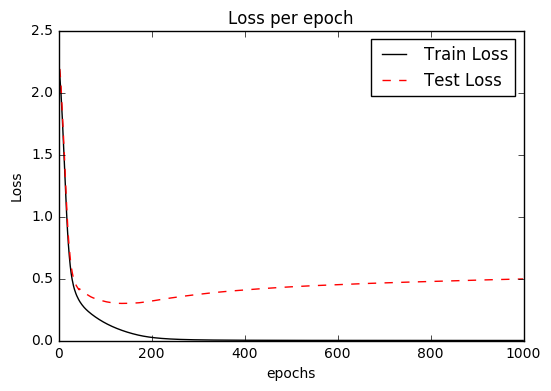

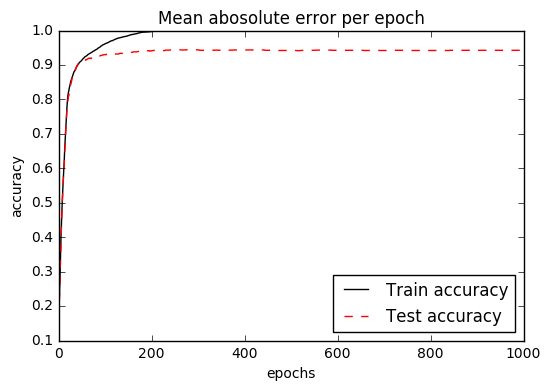

In [1]:
# 多クラス分類問題用のニューラルネット 汎用プログラム

%matplotlib inline
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

# 多クラス分類問題をニューラルネットワークで解くテンプレート。隠れ層の層数は可変。
# 入力データはランダムに並び替えた上で、指定の割合で訓練データと確認データに分割される。

# 入力する部分
# 各隠れ層のノード数。
# 隠れ層の数はここに入力した数値の数になる。num_hiddens = [64, 64, 64]ならば3層。
num_hiddens = [64, 64, 64]    
max_epochs = 1000  # 訓練のステップの数 例）max_epochs = 1000
print_interval = 50    # 途中経過の印刷のインターバル 例）print_interval = 50
filename_data = 'ex4_MNIST_data.csv'    # データのファイル名 例）filename_data = 'ex4_MNIST_data.csv'
# 入力データのうち、訓練に使うデータの割合。
# ratio_for_training = 0.8であれば、80%が訓練に、20％が確認に使われる。
ratio_for_training = 0.8
explanatory_start_column = 1  # 説明変数の最初の列の列番号 例） explanatory_start_column = 1
explanatory_end_column = 784 # 説明変数の最後の列の列番号 例）explanatory_end_column =784
outcome_start_column = 785  # 目的変数の最初の列番号 例）outcome_start_column = 785
outcome_end_column = 794  # 目的変数の最後の列番号 例）outcome_end_column = 794
# 入力はここまで

explanatory_variables = np.arange(explanatory_start_column-1, 
                                  explanatory_end_column)    
outcome_variables = np.arange(outcome_start_column-1, outcome_end_column)

tf.set_random_seed(123)

def inference(x, num_in, num_hiddens, num_out):

    # 重み変数 初期値を標準偏差になるように調整
    def weight_variable(shape):
        initial = np.sqrt(2.0 / shape[0]) * tf.truncated_normal(shape)
        return tf.Variable(initial)

    # バイアス変数
    def bias_variable(shape):
        initial = tf.zeros(shape)
        return tf.Variable(initial)

    for i, num_hidden in enumerate(num_hiddens):
        if i == 0:    # 入力層から隠れ層
            input = x
            input_dim = num_in
        else:        # 隠れ層から隠れ層
            input = output
            input_dim = num_hiddens[i-1]

        W = weight_variable([input_dim, num_hidden])
        b = bias_variable([num_hidden])

        h = tf.nn.relu(tf.matmul(input, W) + b)
        output = h

    # 隠れ層から出力層
    W_out = weight_variable([num_hiddens[-1], num_out])
    b_out = bias_variable([num_out])
    # 多クラス分類の場合は、softmax関数
    y = tf.nn.softmax(tf.matmul(h, W_out) + b_out)   
    
    return y


def loss(y, t):
    # 多クラス分類の場合は以下のロス関数を使う。
    cross_entropy = \
        tf.reduce_mean(-tf.reduce_sum(
                       t * tf.log(tf.clip_by_value(y, 1e-10, 1.0)),
                       reduction_indices=[1]))
    loss = cross_entropy
    return loss

def training(loss):
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001,
                                       beta1=0.9,
                                       beta2=0.999)
    train_step = optimizer.minimize(loss)
    return train_step

def accuracy(y, t):
    # 分類問題の場合は、正解率をみる。
    # 多クラス分類の場合
    correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(t, 1))
    
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

if __name__ == '__main__':

    # データの生成  
    seed = 456
    tf.set_random_seed(seed)
    np.random.seed(seed)

    df1 = pd.read_csv(filename_data, skiprows=[0], header=None)
    df2 = np.array(df1.values.tolist())    
    
    train_indices = np.random.choice(len(df1), 
                                     round(len(df1)*ratio_for_training), 
                                     replace = False)
    test_indices = np.array(list(set(range(len(df1)))-set(train_indices)))
    
    train_set = df2[train_indices]
    test_set = df2[test_indices]
    
    # 列でXとYを分ける。列の番号を指定する必要がある。
    X_train = train_set[:, explanatory_variables]
    Y_train = train_set[:, outcome_variables]
    X_test = test_set[:, explanatory_variables]
    Y_test = test_set[:, outcome_variables]
    
    # 入力データを正規化
    eps = 1e-8
    X_min = X_train.min(axis=0)
    X_max = X_train.max(axis=0)
    X_train = (X_train - X_min)/(X_max - X_min + eps)
    X_test = (X_test - X_min)/(X_max - X_min + eps)

    # モデル設定
    N_train = len(X_train[0])
    num_in = len(X_train[0])
    num_out = len(Y_train[0])

    x = tf.placeholder(tf.float32, shape=[None, num_in])
    t = tf.placeholder(tf.float32, shape=[None, num_out])

    y = inference(x, num_in=num_in, num_hiddens=num_hiddens, num_out=num_out)
    loss = loss(y, t)
    train_step = training(loss)

    accuracy = accuracy(y, t)

    history = {
        'val_loss': [],
        'val_accuracy': [],
        'val_loss_test': [],
        'val_accuracy_test': []
    }

    # モデル学習   

    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)

    for epoch in range(max_epochs):
        sess.run(train_step, feed_dict={x: X_train, t: Y_train})    

        # データを用いた評価
        val_loss = loss.eval(session=sess, feed_dict={
            x: X_train,
            t: Y_train,
        })
        val_accuracy = accuracy.eval(session=sess, feed_dict={
            x: X_train,
            t: Y_train,
        })
        val_loss_test = loss.eval(session=sess, feed_dict={
            x: X_test,
            t: Y_test,
        })
        val_accuracy_test = accuracy.eval(session=sess, feed_dict={
            x: X_test,
            t: Y_test,
        })
        
        # データに対する学習の進み具合を記録
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)
        history['val_loss_test'].append(val_loss_test)
        history['val_accuracy_test'].append(val_accuracy_test)
        
        if (epoch+1) % print_interval == 0:
            print('epoch+1:', epoch+1, 
                  ' train loss:', val_loss, 
                  ' train accuracy:', val_accuracy,
                  ' test loss:', val_loss_test, 
                  ' test accuracy:', val_accuracy_test)

    # 学習の進み具合を可視化
    # 計算ループごとのlossの動きをグラフ化。kは黒、rは赤、-は実線、-- は破線。
    plt.plot(history['val_loss'], 'k-', label='Train Loss')
    plt.plot(history['val_loss_test'], 'r--', label='Test Loss')
    plt.title('Loss per epoch')
    plt.legend(loc='upper right')
    plt.xlabel('epochs')
    plt.ylabel('Loss')
    plt.show()
    
    # 計算ループごとの精度の動きをグラフ化
    plt.plot(history['val_accuracy'], 'k-', label='Train accuracy')
    plt.plot(history['val_accuracy_test'], 'r--', label='Test accuracy')
    plt.title('Mean abosolute error per epoch')
    plt.legend(loc='lower right')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.show()